# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

In [123]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 200

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

## Problem1

The modified Morley-Wang-Xu element method is equivalent to finding $w_{h} \in W_{h}$ and $u_{h 0} \in V_{h 0}$ such that
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h 0}
\end{aligned}
$$
where 
$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

## Problem2

The modified Morley-Wang-Xu element method is also equivalent to
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} \tilde{a}_{h}\left(u_{h}, v_{h}\right)+b_{h}\left(u_{h}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h}
\end{aligned}
$$
where
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$

## Forms and errors

In [124]:
@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))


@BilinearForm
def a_load(u, v, w):
    '''
    for $a_{h}$
    '''
    return ddot(dd(u), dd(v))


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def penalty_1(u, v, w):
    return ddot(-dd(u), prod(w.n, w.n)) * dot(grad(v), w.n)

@BilinearForm
def penalty_2(u, v, w):
    return ddot(-dd(v), prod(w.n, w.n)) * dot(grad(u), w.n) 


@BilinearForm
def penalty_3(u, v, w):
    global mem
    global nn
    global memu
    nn = prod(w.n, w.n)
    mem = w
    memu = u
    return (sigma / w.h) * dot(grad(u), w.n) * dot(grad(v), w.n) 


@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))

## Solver for problem1

In [125]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


def solve_problem1(m):

    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {
        variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()
    }  # intorder: integration order for quadrature

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True))

    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])),
                solver=solver_iter_krylov(Precondition=True))  # cg
    return uh0, basis

## Solver for problem2

In [126]:
def easy_boundary_penalty(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u']))
    return D


def solve_problem2(m):
    global fbasis
    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {
        variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()
    }

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True))
    
    fbasis = FacetBasis(m, element['u'])
    
    p1 = asm(penalty_1, fbasis)
    p2 = asm(penalty_2, fbasis)
    p3 = asm(penalty_3, fbasis)
    P = p1 + p2 + p3

    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2 + P, f2, D=easy_boundary_penalty(basis['u'])), solver=solver_iter_krylov(Precondition=True))  
    # uh0 = solve(*condense(K2 + P, f2, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True)) 
    return uh0, basis

# easy_boundary(basis['u'])

# easy_boundary_penalty(basis['u'])

# m.boundary_nodes()

# Numerical results
> setting boundary condition: $u=0 \ on \ \partial \Omega$

## Parameters 
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$


- `sigma` in $\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}$

## Example 1
$$
u\left(x_{1}, x_{2}\right)=\left(\sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)\right)^{2}
$$

In [127]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                        ((sin(pix))**2))
    llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                          sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
    return (epsilon**2 * llu - lu) * v


def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2


def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy


def ddexact(x, y):
    duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
        pi * x)**2 * sin(pi * y)**2
    duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
        pi * y)
    duyx = duxy
    duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
        pi * y)**2 * sin(pi * x)**2
    return duxx, duxy, duyx, duyy

### Without penalty (Problem1)

In [133]:
refine_time = 5
epsilon_range = 4
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri.init_symmetric()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem1(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
uh0_no_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  1.90  1.32  0.83  0.80
2^-3  1.86  1.82  0.97  0.94
2^-4  1.96  1.93  1.00  0.98
2^-5  1.99  1.98  1.01  0.99
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.71  1.43  0.90  1.40
2^-3  2.26  1.77  0.95  1.70
2^-4  2.20  1.88  1.04  1.75
2^-5  2.05  1.92  1.03  1.60
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.70  1.43  0.90  1.41
2^-3  2.22  1.75  0.92  1.72
2^-4  2.20  1.85  0.96  1.84
2^-5  2.10  1.91  0.99  1.90
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  1.70  1.43  0.90  1.41
2^-3  2.22  1.75  0.92  1.72
2^-4  2.20  1.85  0.96  1.84
2^-5  2.10  1.91  0.99  1.90


### With penalty (Problem2)

In [137]:
sigma = 5
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri.init_symmetric()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem2(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
uh0_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  2.52  1.78  1.21  1.17
2^-3  1.76  1.85  1.01  0.98
2^-4  1.81  1.91  0.98  0.96
2^-5  1.90  1.96  0.99  0.98
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.62  1.29  0.37  1.22
2^-3  1.76  1.59  0.63  1.51
2^-4  1.85  1.60  0.67  1.39
2^-5  1.70  1.51  0.66  1.12
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.62  1.29  0.35  1.24
2^-3  1.77  1.59  0.58  1.56
2^-4  1.93  1.62  0.57  1.58
2^-5  1.98  1.60  0.55  1.57
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  1.62  1.29  0.35  1.24
2^-3  1.77  1.59  0.58  1.56
2^-4  1.93  1.62  0.57  1.58
2^-5  1.98  1.60  0.55  1.57


### Analysising result $uh_{0}$ with and without penalty

`uh0_penalty-uh0_no_penalty`

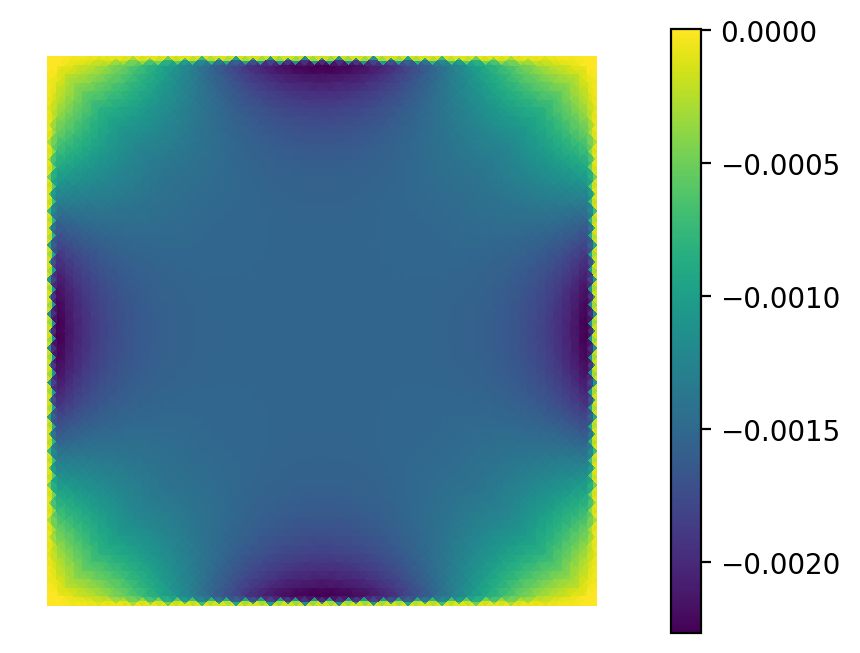

In [138]:
plot(basis['u'], uh0_penalty-uh0_no_penalty, colorbar=True)

`u-uh0_penalty`

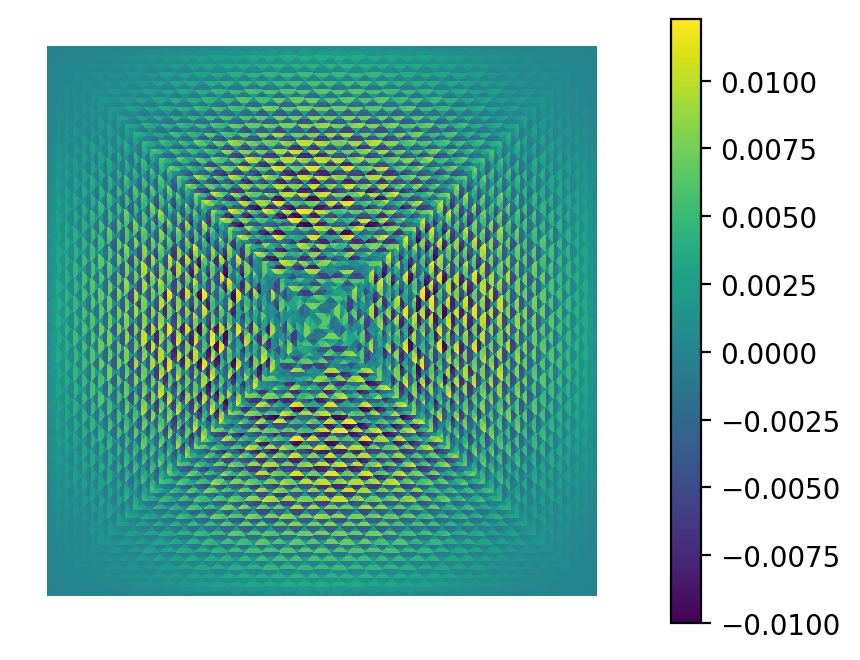

In [145]:
x = basis['u'].doflocs[0]
y = basis['u'].doflocs[1]
u = exact_u(x, y)

plot(basis['u'], u-uh0_penalty, colorbar = True)

Value of `uh0_penalty` on boundary nodes

In [146]:
uh0_penalty[m.boundary_nodes()]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
m = MeshTri.init_symmetric()
m.refine(refine_time)

# fbasis_dof = FacetBasis(m,
#                     ElementTriMorley())

fbasis_dof = FacetBasis(m,
                    ElementTriMorley(),
                    quadrature=(np.array([[0.0, 0.5, 1.0]]), np.array(
                        [1, 1, 1])))  # quadrature: points and weights

p3 = asm(penalty_3, fbasis_dof)

$\partial u_{n}$ of `uh0_without_penalty` on boundary nodes

Data structure: $[n1, n2, n3]$ for each facet

- $n1, n3$ : $\partial u_{n}$ on two ends of a facet

- $n2$ : $\partial u_{n}$ on the middle point of a facet

In [149]:
dot(fbasis_dof.interpolate(uh0_no_penalty).grad, mem.n)

array([[ 8.15825591e-04,  0.00000000e+00, -8.15825591e-04],
       [ 8.15825591e-04,  0.00000000e+00, -8.15825591e-04],
       [ 8.15825591e-04,  0.00000000e+00, -8.15825591e-04],
       [ 8.15825591e-04,  0.00000000e+00, -8.15825591e-04],
       [ 8.15825591e-04, -8.19789829e-18, -8.15825591e-04],
       [ 8.15825591e-04, -8.19789829e-18, -8.15825591e-04],
       [ 8.15825591e-04,  0.00000000e+00, -8.15825591e-04],
       [ 8.15825591e-04, -4.09894915e-18, -8.15825591e-04],
       [-7.14345468e-04,  0.00000000e+00,  7.14345468e-04],
       [-7.14345468e-04,  0.00000000e+00,  7.14345468e-04],
       [-7.14345468e-04,  0.00000000e+00,  7.14345468e-04],
       [-7.14345468e-04,  0.00000000e+00,  7.14345468e-04],
       [-7.14345468e-04,  0.00000000e+00,  7.14345468e-04],
       [-7.14345468e-04, -7.66533237e-16,  7.14345468e-04],
       [-7.14345468e-04, -3.83266618e-16,  7.14345468e-04],
       [-7.14345468e-04,  3.79677535e-16,  7.14345468e-04],
       [-7.40150307e-03,  0.00000000e+00

$\partial u_{n}$ of `uh0_penalty` on boundary nodes

In [150]:
dot(fbasis_dof.interpolate(uh0_penalty).grad, mem.n)

array([[ 9.07738686e-07,  3.40561544e-07, -2.26615599e-07],
       [ 9.05261427e-07,  3.38081218e-07, -2.29098991e-07],
       [ 8.90125283e-07,  3.22956388e-07, -2.44212507e-07],
       [ 9.22832583e-07,  3.55646422e-07, -2.11539740e-07],
       [ 8.76852049e-07,  3.09687700e-07, -2.57476649e-07],
       [ 9.36266599e-07,  3.69075321e-07, -1.98115958e-07],
       [ 9.18893184e-07,  3.51710757e-07, -2.15471671e-07],
       [ 8.94105525e-07,  3.26931109e-07, -2.40243306e-07],
       [-1.28157444e-05, -1.27461504e-05, -1.26765564e-05],
       [-1.28157112e-05, -1.27461216e-05, -1.26765320e-05],
       [-1.28144853e-05, -1.27453600e-05, -1.26762348e-05],
       [-1.28159842e-05, -1.27452390e-05, -1.26744939e-05],
       [-1.28160241e-05, -1.27460777e-05, -1.26761313e-05],
       [-1.28145742e-05, -1.27461349e-05, -1.26776957e-05],
       [-1.28160297e-05, -1.27460997e-05, -1.26761698e-05],
       [-1.28157989e-05, -1.27461253e-05, -1.26764517e-05],
       [-6.37685554e-06, -5.65173562e-06

In [162]:
# ### Showing examples of facets used in caculating penalty and also $\partial u_{n}$

# for i in [0,8]:
#     plt.scatter(mem.x[0][i], mem.x[1][i], s=4, marker='*')
#     plt.axis('square')

## Example 2

$$
u=g(x)p(y)
$$
where
$$
g(x)=\frac{1}{2}\left[\sin (\pi x)+\frac{\pi \varepsilon}{1-e^{-1 / \varepsilon}}\left(e^{-x / \varepsilon}+e^{(x-1) / \varepsilon}-1-e^{-1 / \varepsilon}\right)\right]
$$
$$
p(y)=2 y\left(1-y^{2}\right)+\varepsilon\left[l d(1-2 y)-3 \frac{q}{l}+\left(\frac{3}{l}-d\right) e^{-y / \varepsilon}+\left(\frac{3}{l}+d\right) e^{(y-1) / \varepsilon}\right]
$$
$$
l=1-e^{-1 / \varepsilon}, q=2-l \text { and } d=1 /(q-2 \varepsilon l)
$$

In [173]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    x = w.x[0]
    y = w.x[1]
    return (
        (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
        (12 * y + ep *
         ((exp(-y / ep) *
           (3 / (exp(-1 / ep) - 1) + 1 /
            (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                 (exp(-1 / ep) + 2 * ep *
                                  (exp(-1 / ep) - 1) + 1))) / ep**2)) -
        ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
            (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
        (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                     (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
               (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep *
                 (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
               (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
               (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
         (y**2 - 1)) - ep**2 *
        (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
            (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
         (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                     (exp(-1 / ep) + 2 * ep *
                                      (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                 (exp(-1 / ep) + 2 * ep *
                  (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
          (y**2 - 1)) - 2 *
         (12 * y + ep *
          ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
             (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                 (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                  (exp(-1 / ep) + 2 * ep *
                                   (exp(-1 / ep) - 1) + 1))) / ep**2)) *
         ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
             (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
         (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
             (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
         ((exp(-y / ep) *
           (3 / (exp(-1 / ep) - 1) + 1 /
            (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                 (exp(-1 / ep) + 2 * ep *
                                  (exp(-1 / ep) - 1) + 1))) / ep**4))) * v


def exact_u(x, y):
    return -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
             (2 *
              (exp(-1 / ep) - 1))) * (ep * (exp(
                  (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                   (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                             (exp(-1 / ep) + 2 * ep *
                                              (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) *
                                             (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                             (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                      (y**2 - 1))


def dexact_u(x, y):
    dux = -((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
        (x - 1) / ep) / ep)) /
            (2 *
             (exp(-1 / ep) - 1))) * (ep * (exp(
                 (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                  (exp(-1 / ep) + 2 * ep *
                                   (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                           (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                             (exp(-1 / ep) - 1) + 1)) -
                                           (3 * exp(-1 / ep) + 3) /
                                           (exp(-1 / ep) - 1) -
                                           ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                           (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                     (y**2 - 1))
    duy = (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
           (2 * (exp(-1 / ep) - 1))) * (ep * (
               (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                           (exp(-1 / ep) - 1) + 1) +
               (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                (exp(-1 / ep) + 2 * ep *
                                 (exp(-1 / ep) - 1) + 1))) / ep -
               (exp((y - 1) / ep) *
                (3 / (exp(-1 / ep) - 1) - 1 /
                 (exp(-1 / ep) + 2 * ep *
                  (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
    return dux, duy


def ddexact(x, y):
    duxx = ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
        (x - 1) / ep) / ep**2)) /
            (2 *
             (exp(-1 / ep) - 1))) * (ep * (exp(
                 (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                  (exp(-1 / ep) + 2 * ep *
                                   (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                           (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                             (exp(-1 / ep) - 1) + 1)) -
                                           (3 * exp(-1 / ep) + 3) /
                                           (exp(-1 / ep) - 1) -
                                           ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                           (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                     (y**2 - 1))
    duxy = ((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
        (x - 1) / ep) / ep)) / (2 * (exp(-1 / ep) - 1))) * (ep * (
            (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1) +
            (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                             (exp(-1 / ep) + 2 * ep *
                              (exp(-1 / ep) - 1) + 1))) / ep -
            (exp((y - 1) / ep) *
             (3 / (exp(-1 / ep) - 1) - 1 /
              (exp(-1 / ep) + 2 * ep *
               (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
    duyx = duxy
    duyy = -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
             (2 *
              (exp(-1 / ep) - 1))) * (12 * y + ep *
                                      ((exp(-y / ep) *
                                        (3 / (exp(-1 / ep) - 1) + 1 /
                                         (exp(-1 / ep) + 2 * ep *
                                          (exp(-1 / ep) - 1) + 1))) / ep**2 +
                                       (exp((y - 1) / ep) *
                                        (3 / (exp(-1 / ep) - 1) - 1 /
                                         (exp(-1 / ep) + 2 * ep *
                                          (exp(-1 / ep) - 1) + 1))) / ep**2))
    return duxx, duxy, duyx, duyy

### Without penalty (Problem1)

In [176]:
refine_time = 5
epsilon_range = 4
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri.init_symmetric()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem1(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
uh0_no_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  1.52  1.14  0.76  0.74
2^-3  1.82  1.76  0.94  0.91
2^-4  1.95  1.92  0.99  0.97
2^-5  1.99  1.98  1.00  0.99
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.12  0.98  -0.66  0.89
2^-3  0.68  1.06  -0.27  0.71
2^-4  0.79  1.10  0.24  0.57
2^-5  1.25  1.29  0.57  0.69
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.29  0.63  -0.48  0.60
2^-3  1.39  0.54  -0.51  0.52
2^-4  1.47  0.51  -0.50  0.50
2^-5  1.48  0.51  -0.50  0.50
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  1.29  0.63  -0.48  0.60
2^-3  1.38  0.54  -0.51  0.52
2^-4  1.46  0.51  -0.50  0.50
2^-5  1.49  0.51  -0.50  0.50


### With penalty (Problem2)

In [181]:
sigma = 5
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri.init_symmetric()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem2(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
uh0_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  2.07  1.95  1.24  1.19
2^-3  1.72  1.80  1.09  1.06
2^-4  1.84  1.88  1.02  1.00
2^-5  1.92  1.94  1.00  0.99
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  0.81  0.50  -0.83  0.42
2^-3  0.90  0.64  -0.34  0.52
2^-4  1.10  0.78  0.01  0.57
2^-5  1.17  0.93  0.19  0.58
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  0.74  0.42  -0.50  0.36
2^-3  0.78  0.50  -0.44  0.46
2^-4  0.91  0.53  -0.47  0.48
2^-5  0.97  0.53  -0.49  0.49
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  0.74  0.42  -0.50  0.36
2^-3  0.78  0.50  -0.44  0.46
2^-4  0.91  0.53  -0.47  0.48
2^-5  0.96  0.53  -0.49  0.49


### Analysising result $uh_{0}$ with and without penalty

`uh0_penalty-uh0_no_penalty`

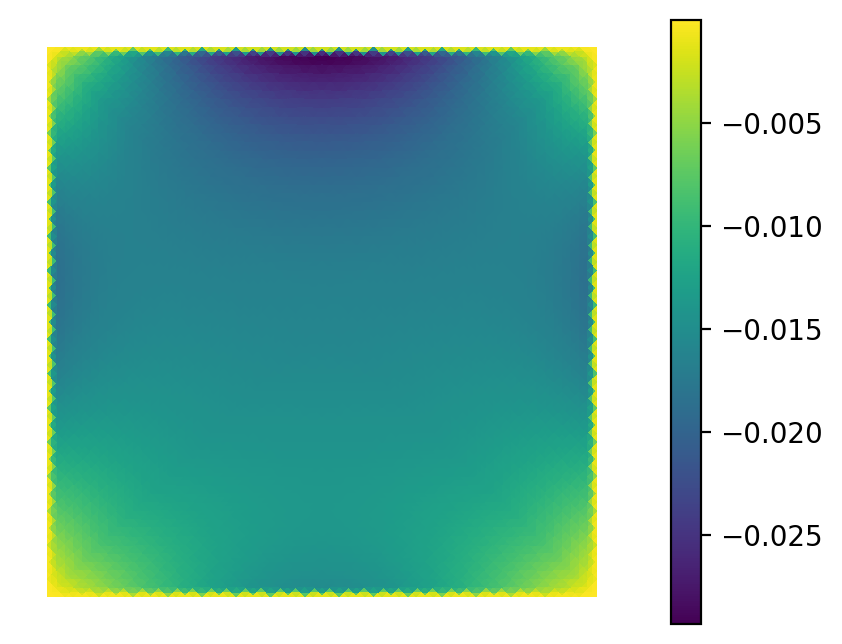

In [182]:
plot(basis['u'], uh0_penalty-uh0_no_penalty, colorbar=True)

`u-uh0_penalty`

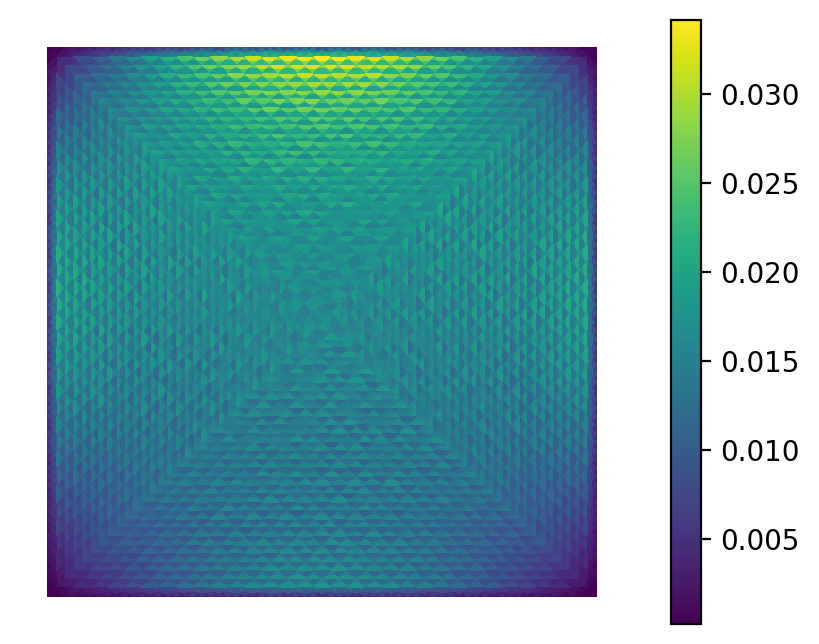

In [183]:
x = basis['u'].doflocs[0]
y = basis['u'].doflocs[1]
u = exact_u(x, y)

plot(basis['u'], u-uh0_penalty, colorbar = True)

Value of `uh0_penalty` on boundary nodes

In [184]:
uh0_penalty[m.boundary_nodes()]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [185]:
m = MeshTri.init_symmetric()
m.refine(refine_time)

# fbasis_dof = FacetBasis(m,
#                     ElementTriMorley())

fbasis_dof = FacetBasis(m,
                    ElementTriMorley(),
                    quadrature=(np.array([[0.0, 0.5, 1.0]]), np.array(
                        [1, 1, 1])))  # quadrature: points and weights

p3 = asm(penalty_3, fbasis_dof)

$\partial u_{n}$ of `uh0_without_penalty` on boundary nodes

Data structure: $[n1, n2, n3]$ for each facet

- $n1, n3$ : $\partial u_{n}$ on two ends of a facet

- $n2$ : $\partial u_{n}$ on the middle point of a facet

In [186]:
dot(fbasis_dof.interpolate(uh0_no_penalty).grad, mem.n)

array([[ 4.90335655e-02,  0.00000000e+00, -4.90335655e-02],
       [ 4.90799502e-02,  0.00000000e+00, -4.90799502e-02],
       [ 4.90335655e-02,  0.00000000e+00, -4.90335655e-02],
       [ 4.90799502e-02,  0.00000000e+00, -4.90799502e-02],
       [ 9.28847628e-02, -9.33361060e-16, -9.28847628e-02],
       [ 9.60331552e-02, -9.64997970e-16, -9.60331552e-02],
       [ 9.28847628e-02,  0.00000000e+00, -9.28847628e-02],
       [ 9.60331552e-02, -4.82498985e-16, -9.60331552e-02],
       [-2.40221159e-03,  0.00000000e+00,  2.40221159e-03],
       [-2.40221159e-03,  0.00000000e+00,  2.40221159e-03],
       [-1.44835149e-02,  0.00000000e+00,  1.44835149e-02],
       [ 9.88742273e-03,  0.00000000e+00, -9.88742273e-03],
       [-1.44835149e-02,  0.00000000e+00,  1.44835149e-02],
       [ 9.88742273e-03, -5.91180348e-15, -9.88742273e-03],
       [-4.69528652e-03, -4.90198389e-15,  4.69528652e-03],
       [-4.69528652e-03,  4.87839339e-15,  4.69528652e-03],
       [-3.62899124e-02,  0.00000000e+00

$\partial u_{n}$ of `uh0_penalty` on boundary nodes

In [187]:
dot(fbasis_dof.interpolate(uh0_penalty).grad, mem.n)

array([[ 1.50961330e-05,  2.50999023e-06, -1.00761525e-05],
       [ 1.50969121e-05,  2.50624285e-06, -1.00844264e-05],
       [ 1.50961390e-05,  2.50999619e-06, -1.00761466e-05],
       [ 1.50969061e-05,  2.50623686e-06, -1.00844324e-05],
       [ 2.67380762e-05,  3.90989518e-06, -1.89182858e-05],
       [ 2.67884161e-05,  3.65277443e-06, -1.94828672e-05],
       [ 2.67370672e-05,  3.90885054e-06, -1.89193661e-05],
       [ 2.67894253e-05,  3.65381930e-06, -1.94817867e-05],
       [-8.25528504e-05, -8.23182823e-05, -8.20837142e-05],
       [-8.25528505e-05, -8.23182822e-05, -8.20837140e-05],
       [-9.73363558e-05, -9.59220902e-05, -9.45078246e-05],
       [-9.70161335e-05, -9.79816066e-05, -9.89470797e-05],
       [-9.73363509e-05, -9.59220831e-05, -9.45078153e-05],
       [-9.70161401e-05, -9.79816121e-05, -9.89470841e-05],
       [-1.62775473e-04, -1.62316993e-04, -1.61858513e-04],
       [-1.62775470e-04, -1.62316993e-04, -1.61858516e-04],
       [-5.80593532e-05, -5.45157620e-05

In [157]:
# ### Analysising results $u$ and $u_{n}$ with penalty

# # x = mem.x[0]
# # y = mem.x[1]
# plot(basis['u'], uh0-uh1, colorbar=True)

# x = basis['u'].doflocs[0]
# y = basis['u'].doflocs[1]
# u = exact_u(x, y)
# plot(basis['u'], u-uh0, colorbar=True)

# uh0[m.boundary_nodes()]

# m = MeshTri.init_symmetric()
# m.refine(2)

# fbasis_dof = FacetBasis(m,
#                     ElementTriMorley(),
#                     quadrature=(np.array([[0.0, 0.5, 1.0]]), np.array(
#                         [1, 1, 1])))  # quadrature: points and weights

# p3 = asm(penalty_3, fbasis_dof)

# for i in range(mem.x.shape[1]):
#     plt.scatter(mem.x[0][i], mem.x[1][i], s=10, marker='*')
#     plt.axis('square')

# dot(fbasis.interpolate(uh1).grad, mem.n)

# dot(fbasis.interpolate(uh0).grad, mem.n)